# Implementation of knn algorithm from scratch


Goal here is to recreate the knn algorithm for both regression and classification to gain better understanding of how it works.

In [20]:
# Tell matplotlib to not open a new window for each plot
%matplotlib inline

# Import a bunch of libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
import seaborn as sns

# Get Data and Load into Environment

In [15]:
# load the Iris Dataset
iris = load_iris()
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [38]:
print(type(iris))

<class 'sklearn.utils.Bunch'>


In [54]:
pd_iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

pd_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


# Preprocess Data
**Investigate the data**

- Structure
- Data Types
- Features/Feature Names

In [11]:
# Names of Features (column names)
print(iris.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [21]:
# Integers representing the species: 0 = Setosa, 1 = Versicolor, 2 = Virginica
print(iris.target_names)
#print(iris.target)

['setosa' 'versicolor' 'virginica']


In [14]:
# Total of 150 observations and 4 features
print(iris.data.shape)

(150, 4)


In [31]:
# rename for ease of use
xdata = iris.data

In [32]:
ydata = iris.target

In [30]:
class_labels = iris.target_names
class_labels

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

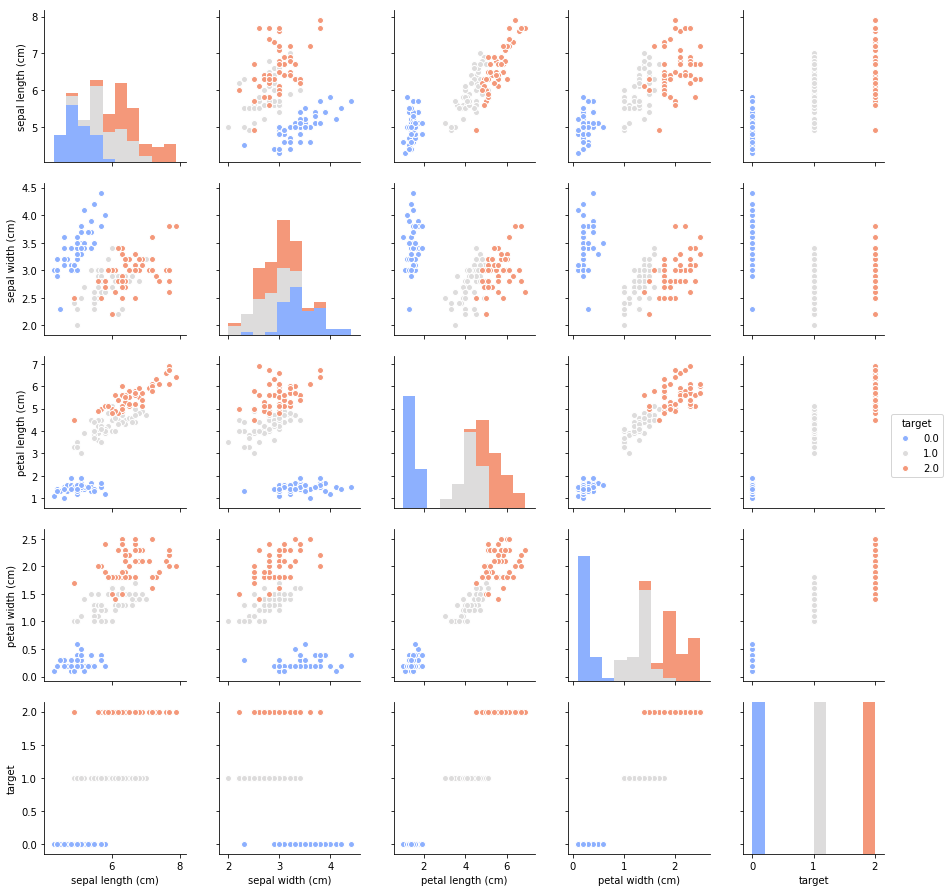

In [48]:
sns.pairplot(pd_iris,hue='target',palette='coolwarm')

In [47]:
np.corrcoef(xdata.T)

array([[ 1.        , -0.10936925,  0.87175416,  0.81795363],
       [-0.10936925,  1.        , -0.4205161 , -0.35654409],
       [ 0.87175416, -0.4205161 ,  1.        ,  0.9627571 ],
       [ 0.81795363, -0.35654409,  0.9627571 ,  1.        ]])

We've found highly correlated variables in between petal width and petal length (0.96).  Additionally, petal width and sepal length are correlated at 0.81, while petal length and sepal length have a correlation coefficient of 0.87.  


We can now look into performing a training/validation split. For this data, it should be reasonable to say there are no time series elements at play here. Therefore random sampling should really be OK.

We should also note that we have 150 observations, and that we will have to set aside some for validation. This would be potentially a good case for using cross validation or something similar to maximize the data we can train on, but for now I'll put this concern aside. Let's do our test/train split...

# Shuffle the data
#### But make sure that the features and accompanying labels stay in sync.

In [127]:
np.random.seed(0)
shuffle = np.random.permutation(np.arange(xdata.shape[0]))
xdata, ydata = xdata[shuffle], ydata[shuffle]

# Train Test Split
#### Use train_test_split to split data into:
1. training set
2. dev set
3. testing set

In [122]:
from sklearn.model_selection import train_test_split

In [172]:
# Split into training and testing.  
# The test size should yield 100 samples for "train" data, and 50 for test data

x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size = 0.33, random_state = 101)    

In [173]:
# check shapes
print('x_train')
print(x_train.shape)
print('x_test')
print(x_test.shape)
print('y_train')
print(y_train.shape)
print('y_test')
print(y_test.shape)

x_train
(100, 4)
x_test
(50, 4)
y_train
(100,)
y_test
(50,)


In [174]:
# Run train_test_split once more
# This time run on x_test, y_test with a test size of 0.5
# This splits the test data in half, assigning one half to test and one half to dev

x_dev, x_test, y_dev, y_test = train_test_split(x_test, y_test, test_size = 0.5)

In [175]:
# check shapes
# each shape should be (25,4)
print('x_dev')
print(x_dev.shape)
print('x_test')
print(x_test.shape)
print('y_dev')
print(y_dev.shape)
print('y_test')
print(y_test.shape)

x_dev
(25, 4)
x_test
(25, 4)
y_dev
(25,)
y_test
(25,)


# Using KNN
#### Import KNeighbors Classifier from scikit learn

In [176]:
from sklearn.neighbors import KNeighborsClassifier

#### Create a KNN model instance with n_neighbors = 1

In [177]:
knn = KNeighborsClassifier(n_neighbors=1)

#### Fit this KNN model to the training data

In [178]:
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

# Predictions and Evaluations

#### Use the predict method to predict values using the KNN model and x_dev.

In [179]:
pred = knn.predict(x_dev)

**Create a confusion matrix and classification report**

In [180]:
from sklearn.metrics import classification_report,confusion_matrix

In [181]:
print(confusion_matrix(y_dev,pred))

[[ 9  0  0]
 [ 0 10  2]
 [ 0  0  4]]


In [182]:
print(classification_report(y_dev,pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       1.00      0.83      0.91        12
          2       0.67      1.00      0.80         4

avg / total       0.95      0.92      0.92        25



# Choosing a K Value
Let's go ahead and use the elbow method to pick a good K Value!

**Create a for loop that trains various KNN models with different k values, then keep track of the error_rate for each of these models with a list. Refer to the lecture if you are confused on this step.**

In [183]:
error_rate = []

for i in range (1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_dev)
    error_rate.append(np.mean(pred_i != y_test))

Text(0,0.5,'Error Rate')

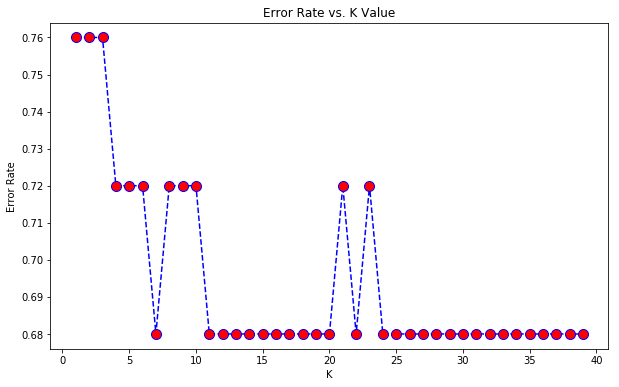

In [184]:
plt.figure(figsize = (10,6))
plt.plot(range(1,40), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o',
        markerfacecolor = 'red', markersize = 10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

# Retrain with new K Value

**Retrain your model with the best K value and re-do the classification report and the confusion matrix.**

In [185]:
# Now with K=14

knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(x_train,y_train)
pred = knn.predict(x_dev)

print('With K=14')
print('\n')
print(confusion_matrix(y_dev,pred))
print('\n')
print(classification_report(y_dev,pred))

With K=14


[[ 9  0  0]
 [ 0 11  1]
 [ 0  0  4]]


             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       1.00      0.92      0.96        12
          2       0.80      1.00      0.89         4

avg / total       0.97      0.96      0.96        25



In [186]:
X_new = np.array([[5,2.9,1,0.2]])
print("X_new.shape:", X_new.shape)

X_new.shape: (1, 4)


In [187]:
prediction = knn.predict(X_new)
print("prediction:", prediction)
print("Predicted target name:", iris['target_names'][prediction])

prediction: [0]
Predicted target name: ['setosa']


In [188]:
# evaluating the model using the test set

y_pred = knn.predict(x_test)
print("Test set predictions:\n", y_pred)

Test set predictions:
 [0 0 0 0 2 2 2 2 1 1 1 0 1 2 0 0 2 0 2 2 2 1 2 2 1]


In [189]:
print("Test set score: {:.2f}".format(np.mean(y_pred == y_test)))

Test set score: 1.00
